<a href="https://colab.research.google.com/github/Mrcl3/O6EQTwpkNwvulbOa/blob/master/talent_search_with_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install unidecode
!pip install gensim
!pip install transformers
!pip install sentence-transformers



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
  Cre

In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from unidecode import unidecode
import string
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Read the data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Aprziva/O6EQTwpkNwvulbOa/potential-talents - Aspiring human resources - seeking human resources.csv')

## Define the sentence to be checked

# Preprocessing

In [5]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [6]:
df = df.drop_duplicates(subset=['job_title', 'location', 'connection']).reset_index(drop=True)
df.tail(55)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN
9,11,Student at Chapman University,"Lake Forest, California",2,NaN


In [7]:
df.shape

(53, 5)

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from unidecode import unidecode

def preprocess(sentence):
    # Converting the words to lowercase
    sentence = sentence.lower()

    # Collecting a list of stop words from nltk and punctuation from the string class
    stopset = stopwords.words('english') + list(string.punctuation)

    # Remove stop words and punctuations from the string
    words = word_tokenize(sentence)
    words = [i for i in words if i.lower() not in stopset and not any(char in string.punctuation for char in i)]
    new_sentence = " ".join(words)

    # Remove non-ASCII characters
    new_sentence = unidecode(new_sentence)

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(new_sentence)
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)



In [9]:
df['job_title'] = df['job_title'].apply(preprocess)


In [10]:
df['job_title']

0     2019 bauer college business graduate magna cum...
1     native english teacher epik english program korea
2                  aspiring human resource professional
3                   people development coordinator ryan
4          advisory board member celal bayar university
5                    aspiring human resource specialist
6     student humber college aspiring human resource...
7                                  hr senior specialist
8       seeking human resource hris generalist position
9                            student chapman university
10    svp chro marketing communication csr officer e...
11    human resource coordinator intercontinental bu...
12    aspiring human resource management student see...
13                   seeking human resource opportunity
14    experienced retail manager aspiring human reso...
15      human resource staffing recruiting professional
16                  human resource specialist luxottica
17    director human resource north america grou

# Word2Vec model

In [11]:
sentences = []
for item in df['job_title'].values:
  # Tokenize the sentence into a list of words
  words = nltk.word_tokenize(item)

  # Add the list of words to the sentences list
  sentences.append(words)
  model= Word2Vec(sentences,min_count=1,vector_size=300,workers=4)



In [12]:
print(model)

Word2Vec<vocab=172, vector_size=300, alpha=0.025>


In [13]:
model.save("word2vec.model")
model.save("model.bin")

In [14]:
model = Word2Vec.load('model.bin')

# Using the model to calculate similarities

In [15]:
similarity_array = []
# Define two example sentences
sentence2 = "aspiring human resources"
for item in df['job_title'].values:
  # Tokenize the sentences into lists of words
  tokens1 = nltk.word_tokenize(item)
  tokens2 = nltk.word_tokenize(sentence2)

  # Calculate the similarity between the two sentences
  similarity = model.wv.n_similarity(tokens1, tokens2)
  similarity_array.append(similarity)
df['similarities'] = similarity_array

In [16]:
df.tail(5)

,id,job_title,location,connection,fit,similarities
48,100,aspiring human resource manager graduating may...,"Cape Girardeau, Missouri",103,NaN,0.564992
49,101,human resource generalist loparex,"Raleigh-Durham, North Carolina Area",500+,NaN,0.395508
50,102,business intelligence analytics traveler,Greater New York City Area,49,NaN,0.009410
51,103,always set success,Greater Los Angeles Area,500+,NaN,-0.001944
52,104,director administration excellence logging,"Katy, Texas",500+,NaN,0.092985


# Basic fit ranking (similarities + connection scaled to (0,1)

In [17]:
from sklearn.preprocessing import MinMaxScaler

#Select the input features for ranking
features = ['similarities', 'connection']

# Replace '500+' with 500 in the 'connections' column
df['connection'] = df['connection'].replace('500+ ', '500')

df['connection'] = pd.to_numeric(df['connection'])
print(df['connection'])
# Scale the 'connections' column to a range of 0 to 1
scaler = MinMaxScaler()
df['connection'] = scaler.fit_transform(df['connection'].values.reshape(-1, 1))

# Normalize the remaining features to a range of 0 to 1
df[features] = scaler.fit_transform(df[features])

# Calculate the ranking score
df['ranking'] = 0.8*df['similarities'] * 0.2*df['connection']

# Normalize the ranking score to a range of 0 to 1
df['ranking'] = scaler.fit_transform(df['ranking'].values.reshape(-1, 1))

# Print the ranked candidates
print(df[['job_title', 'ranking']])


0      85
1     500
2      44
3     500
4     500
5       1
6      61
7     500
8     500
9       2
10    500
11    500
12    500
13    390
14     57
15    500
16    500
17    500
18     82
19    500
20      5
21      7
22     16
23    500
24    212
25    409
26    500
27      7
28     52
29    455
30    174
31    268
32     50
33    500
34      4
35     40
36     18
37    349
38    155
39     39
40     64
41      9
42    415
43     57
44     19
45     71
46      4
47     48
48    103
49    500
50     49
51    500
52    500
Name: connection, dtype: int64
                                            job_title   ranking
0   2019 bauer college business graduate magna cum...  0.098715
1   native english teacher epik english program korea  0.012769
2                aspiring human resource professional  0.102696
3                 people development coordinator ryan  0.130708
4        advisory board member celal bayar university  0.194983
5                  aspiring human resource specialist  

In [18]:
df.head()

,id,job_title,location,connection,fit,similarities,ranking
0,1,2019 bauer college business graduate magna cum...,"Houston, Texas",0.168337,NaN,0.460152,0.098715
1,2,native english teacher epik english program korea,Kanada,1.000000,NaN,0.010020,0.012769
2,3,aspiring human resource professional,"Raleigh-Durham, North Carolina Area",0.086172,NaN,0.935151,0.102696
3,4,people development coordinator ryan,"Denton, Texas",1.000000,NaN,0.102564,0.130708
4,5,advisory board member celal bayar university,"İzmir, Türkiye",1.000000,NaN,0.153000,0.194983


# Job titles ranking

In [19]:
# Sort the DataFrame in ascending order based on a column
df_sorted = df.sort_values('ranking', ascending=False)

# Print the sorted DataFrame
print(df_sorted[['job_title', 'ranking', 'similarities', 'connection']])

                                            job_title   ranking  similarities  \
12  aspiring human resource management student see...  1.000000      0.784684   
16                human resource specialist luxottica  0.716094      0.561908   
49                  human resource generalist loparex  0.703923      0.552358   
8     seeking human resource hris generalist position  0.658423      0.516655   
13                 seeking human resource opportunity  0.580764      0.584583   
25                 human conflict policy compensation  0.571468      0.548438   
26                   human resource generalist schwan  0.567157      0.445040   
17  director human resource north america groupe b...  0.561285      0.440431   
15    human resource staffing recruiting professional  0.541803      0.425144   
11  human resource coordinator intercontinental bu...  0.535450      0.420159   
23  nortia staffing seeking human resource payroll...  0.509338      0.399670   
42  seeking human resource o

# Try with BERT

In [20]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Selected words for similarity comparison
selected_words = ['aspiring', 'human', 'resource']

# Tokenize and encode all sentences and selected words together
tokenized_texts = tokenizer(df['job_title'].tolist(), padding=True, truncation=True, return_tensors='pt')
tokenized_selected_words = tokenizer(selected_words, padding=True, truncation=True, return_tensors='pt')

# Obtain BERT embeddings for all tokens
with torch.no_grad():
    outputs = model(**tokenized_texts)
    sentence_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Sentence embeddings

    outputs_selected_words = model(**tokenized_selected_words)
    word_embeddings = outputs_selected_words.last_hidden_state[:, 0, :].numpy()  # Word embeddings

# Calculate cosine similarity between sentence embedding and word embeddings
similarity_scores = []
for i in range(len(df)):
    sentence_embedding = sentence_embeddings[i]
    scores = {}
    for j, word in enumerate(selected_words):
        word_embedding = word_embeddings[j]
        score = cosine_similarity(sentence_embedding.reshape(1, -1), word_embedding.reshape(1, -1)).item()
        scores[word] = score
    similarity_scores.append(scores)

# Reshape similarity scores and convert to DataFrame
similarity_scores = pd.DataFrame(similarity_scores, index=range(len(df)))
similarity_scores.columns = selected_words

# Merge similarity scores with the original DataFrame
df = pd.concat([df, similarity_scores], axis=1)

print(df)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


     id                                          job_title  \
0     1  2019 bauer college business graduate magna cum...   
1     2  native english teacher epik english program korea   
2     3               aspiring human resource professional   
3     4                people development coordinator ryan   
4     5       advisory board member celal bayar university   
5     6                 aspiring human resource specialist   
6     7  student humber college aspiring human resource...   
7     8                               hr senior specialist   
8    10    seeking human resource hris generalist position   
9    11                         student chapman university   
10   12  svp chro marketing communication csr officer e...   
11   13  human resource coordinator intercontinental bu...   
12   27  aspiring human resource management student see...   
13   28                 seeking human resource opportunity   
14   66  experienced retail manager aspiring human reso...   
15   67 

In [21]:
df.head()

,id,job_title,location,connection,fit,similarities,ranking,aspiring,human,resource
0,1,2019 bauer college business graduate magna cum...,"Houston, Texas",0.168337,NaN,0.460152,0.098715,0.802823,0.849149,0.811189
1,2,native english teacher epik english program korea,Kanada,1.000000,NaN,0.010020,0.012769,0.852012,0.874882,0.874288
2,3,aspiring human resource professional,"Raleigh-Durham, North Carolina Area",0.086172,NaN,0.935151,0.102696,0.760295,0.807430,0.757689
3,4,people development coordinator ryan,"Denton, Texas",1.000000,NaN,0.102564,0.130708,0.853755,0.899812,0.868571
4,5,advisory board member celal bayar university,"İzmir, Türkiye",1.000000,NaN,0.153000,0.194983,0.794921,0.843250,0.816467


In [22]:
df['avarage'] = (df['aspiring'] + df['human'] + df['resource'])/3

In [23]:
df.head()

,id,job_title,location,connection,fit,similarities,ranking,aspiring,human,resource,avarage
0,1,2019 bauer college business graduate magna cum...,"Houston, Texas",0.168337,NaN,0.460152,0.098715,0.802823,0.849149,0.811189,0.821054
1,2,native english teacher epik english program korea,Kanada,1.000000,NaN,0.010020,0.012769,0.852012,0.874882,0.874288,0.867061
2,3,aspiring human resource professional,"Raleigh-Durham, North Carolina Area",0.086172,NaN,0.935151,0.102696,0.760295,0.807430,0.757689,0.775138
3,4,people development coordinator ryan,"Denton, Texas",1.000000,NaN,0.102564,0.130708,0.853755,0.899812,0.868571,0.874046
4,5,advisory board member celal bayar university,"İzmir, Türkiye",1.000000,NaN,0.153000,0.194983,0.794921,0.843250,0.816467,0.818213


In [24]:
from sklearn.preprocessing import MinMaxScaler

#Select the input features for ranking
features = ['avarage', 'connection']

# Replace '500+' with 500 in the 'connections' column
df['connection'] = df['connection'].replace('500+ ', '500')

df['connection'] = pd.to_numeric(df['connection'])

# Scale the 'connections' column to a range of 0 to 1
scaler = MinMaxScaler()
df['connection'] = scaler.fit_transform(df['connection'].values.reshape(-1, 1))

# Normalize the remaining features to a range of 0 to 1
df[features] = scaler.fit_transform(df[features])

# Calculate the ranking score
df['ranking_BERT'] = 0.8*df['avarage'] * 0.2*df['connection']

# Normalize the ranking score to a range of 0 to 1
df['ranking_BERT'] = scaler.fit_transform(df['ranking_BERT'].values.reshape(-1, 1))

# Print the ranked candidates
print(df[['job_title', 'ranking','ranking_BERT']])


                                            job_title   ranking  ranking_BERT
0   2019 bauer college business graduate magna cum...  0.098715      0.094319
1   native english teacher epik english program korea  0.012769      0.745856
2                aspiring human resource professional  0.102696      0.032324
3                 people development coordinator ryan  0.130708      0.774029
4        advisory board member celal bayar university  0.194983      0.548840
5                  aspiring human resource specialist  0.000000      0.000000
6   student humber college aspiring human resource...  0.097855      0.078014
7                                hr senior specialist  0.086114      0.691845
8     seeking human resource hris generalist position  0.658423      0.681701
9                          student chapman university  0.000181      0.001476
10  svp chro marketing communication csr officer e...  0.148835      0.597022
11  human resource coordinator intercontinental bu...  0.535450 

In [25]:
# Sort the DataFrame in ascending order based on a column
df_sorted = df.sort_values('ranking', ascending=False)

# Print the sorted DataFrame
print(df_sorted[['job_title', 'ranking','ranking_BERT']])

                                            job_title   ranking  ranking_BERT
12  aspiring human resource management student see...  1.000000      0.399975
16                human resource specialist luxottica  0.716094      1.000000
49                  human resource generalist loparex  0.703923      0.839160
8     seeking human resource hris generalist position  0.658423      0.681701
13                 seeking human resource opportunity  0.580764      0.743979
25                 human conflict policy compensation  0.571468      0.398919
26                   human resource generalist schwan  0.567157      0.877701
17  director human resource north america groupe b...  0.561285      0.652341
15    human resource staffing recruiting professional  0.541803      0.743885
11  human resource coordinator intercontinental bu...  0.535450      0.852687
23  nortia staffing seeking human resource payroll...  0.509338      0.691810
42  seeking human resource opportunity open travel...  0.485328 

In [26]:
# Sort the DataFrame in ascending order based on a column
df_sorted = df.sort_values('ranking_BERT', ascending=False)

# Print the sorted DataFrame
print(df_sorted[['job_title', 'ranking','ranking_BERT', 'connection']])

                                            job_title   ranking  ranking_BERT  \
16                human resource specialist luxottica  0.716094      1.000000   
26                   human resource generalist schwan  0.567157      0.877701   
52         director administration excellence logging  0.203254      0.865002   
51                                 always set success  0.046150      0.855278   
11  human resource coordinator intercontinental bu...  0.535450      0.852687   
49                  human resource generalist loparex  0.703923      0.839160   
19          human resource generalist scottmadden inc  0.482098      0.822557   
3                 people development coordinator ryan  0.130708      0.774029   
1   native english teacher epik english program korea  0.012769      0.745856   
13                 seeking human resource opportunity  0.580764      0.743979   
15    human resource staffing recruiting professional  0.541803      0.743885   
33  rrp brand portfolio exec

# SBERT

In [27]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')


In [28]:
sentences = list(df['job_title'].values)
sentences

['2019 bauer college business graduate magna cum laude aspiring human resource professional',
 'native english teacher epik english program korea',
 'aspiring human resource professional',
 'people development coordinator ryan',
 'advisory board member celal bayar university',
 'aspiring human resource specialist',
 'student humber college aspiring human resource generalist',
 'hr senior specialist',
 'seeking human resource hris generalist position',
 'student chapman university',
 'svp chro marketing communication csr officer engie houston woodland energy gphr sphr',
 'human resource coordinator intercontinental buckhead atlanta',
 'aspiring human resource management student seeking internship',
 'seeking human resource opportunity',
 'experienced retail manager aspiring human resource professional',
 'human resource staffing recruiting professional',
 'human resource specialist luxottica',
 'director human resource north america groupe beneteau',
 'retired army national guard recrui

In [29]:
# Encode the target sentence and other sentences
target_sentence = 'aspiring human resource'
target_embedding = model.encode([target_sentence])[0]
sentence_embeddings = model.encode(sentences)

# Calculate cosine similarity between the target sentence and other sentences
similarities = cosine_similarity([target_embedding], sentence_embeddings)[0]

# Add similarities_SBERt to the dataframe
df['similarities_SBERT'] = similarities
# Sort the sentences based on their similarity scores
results = sorted(zip(sentences, similarities), key=lambda x: x[1], reverse=True)

# Print the most similar sentences
for sentence, similarity in results:
    print(f"Similarity: {similarity:.4f}\tSentence: {sentence}")

Similarity: 0.7982	Sentence: aspiring human resource professional
Similarity: 0.7982	Sentence: aspiring human resource professional
Similarity: 0.7820	Sentence: seeking human resource opportunity
Similarity: 0.7614	Sentence: aspiring human resource specialist
Similarity: 0.7600	Sentence: seeking human resource position
Similarity: 0.5887	Sentence: aspiring human resource professional energetic leader
Similarity: 0.5831	Sentence: seeking human resource hris generalist position
Similarity: 0.5791	Sentence: aspiring human resource manager seeking internship human resource
Similarity: 0.5609	Sentence: human resource professional
Similarity: 0.5128	Sentence: aspiring human resource management student seeking internship
Similarity: 0.4970	Sentence: aspiring human resource professional passionate helping create inclusive engaging work environment
Similarity: 0.4840	Sentence: director human resource ey
Similarity: 0.4597	Sentence: seeking human resource opportunity open travel relocation
Simil

In [30]:
from sklearn.preprocessing import MinMaxScaler

#Select the input features for ranking
features = ['connection']

# Replace '500+' with 500 in the 'connections' column
df['connection'] = df['connection'].replace('500+ ', '500')

df['connection'] = pd.to_numeric(df['connection'])
print(df['connection'])
# Scale the 'connections' column to a range of 0 to 1
scaler = MinMaxScaler()
df['connection'] = scaler.fit_transform(df['connection'].values.reshape(-1, 1))

# Normalize the remaining features to a range of 0 to 1
df[features] = scaler.fit_transform(df[features])

# Calculate the ranking score
df['ranking_SBERT'] = 0.8*similarities*0.2*df['connection']

# Normalize the ranking score to a range of 0 to 1
df['ranking_SBERT'] = scaler.fit_transform(df['ranking_SBERT'].values.reshape(-1, 1))

# Print the ranked candidates
print(df[['job_title', 'ranking','ranking_SBERT']])


0     0.168337
1     1.000000
2     0.086172
3     1.000000
4     1.000000
5     0.000000
6     0.120240
7     1.000000
8     1.000000
9     0.002004
10    1.000000
11    1.000000
12    1.000000
13    0.779559
14    0.112224
15    1.000000
16    1.000000
17    1.000000
18    0.162325
19    1.000000
20    0.008016
21    0.012024
22    0.030060
23    1.000000
24    0.422846
25    0.817635
26    1.000000
27    0.012024
28    0.102204
29    0.909820
30    0.346693
31    0.535070
32    0.098196
33    1.000000
34    0.006012
35    0.078156
36    0.034068
37    0.697395
38    0.308617
39    0.076152
40    0.126253
41    0.016032
42    0.829659
43    0.112224
44    0.036072
45    0.140281
46    0.006012
47    0.094188
48    0.204409
49    1.000000
50    0.096192
51    1.000000
52    1.000000
Name: connection, dtype: float64
                                            job_title   ranking  ranking_SBERT
0   2019 bauer college business graduate magna cum...  0.098715       0.141204
1   native eng

In [31]:
# Sort the DataFrame in ascending order based on a column
df_SBERT = df.sort_values('ranking_SBERT', ascending=False)
df_SBERT

,id,job_title,location,connection,fit,similarities,ranking,aspiring,human,resource,avarage,ranking_BERT,similarities_SBERT,ranking_SBERT
13,28,seeking human resource opportunity,"Chicago, Illinois",0.779559,NaN,0.584583,0.580764,0.946720,0.862424,0.947124,0.896309,0.743979,0.781953,1.000000
8,10,seeking human resource hris generalist position,Greater Philadelphia Area,1.000000,NaN,0.516655,0.658423,0.835943,0.858868,0.858651,0.640236,0.681701,0.583060,0.959326
12,27,aspiring human resource management student see...,"Houston, Texas Area",1.000000,NaN,0.784684,1.000000,0.771051,0.800865,0.771994,0.375645,0.399975,0.512805,0.851571
15,67,human resource staffing recruiting professional,"Jackson, Mississippi Area",1.000000,NaN,0.425144,0.541803,0.847956,0.879553,0.872207,0.698637,0.743885,0.384479,0.654748
26,78,human resource generalist schwan,Amerika Birleşik Devletleri,1.000000,NaN,0.445040,0.567157,0.896878,0.887943,0.914429,0.824313,0.877701,0.384259,0.654412
42,94,seeking human resource opportunity open travel...,Amerika Birleşik Devletleri,0.829659,NaN,0.459019,0.485328,0.850068,0.847818,0.861846,0.648153,0.572574,0.459721,0.650045
17,69,director human resource north america groupe b...,"Greater Grand Rapids, Michigan Area",1.000000,NaN,0.440431,0.561285,0.824047,0.863262,0.844315,0.612661,0.652341,0.364914,0.624740
37,89,director human resource ey,Greater Atlanta Area,0.697395,NaN,0.478063,0.424882,0.848091,0.909349,0.876682,0.742081,0.551041,0.483982,0.582734
49,101,human resource generalist loparex,"Raleigh-Durham, North Carolina Area",1.000000,NaN,0.552358,0.703923,0.877896,0.889282,0.903404,0.788116,0.839160,0.308993,0.538971
23,75,nortia staffing seeking human resource payroll...,"San Jose, California",1.000000,NaN,0.399670,0.509338,0.833157,0.862895,0.864929,0.649730,0.691810,0.301036,0.526767


In [32]:
df['ranking_SBERT_binary'] = df['ranking_SBERT'].apply(lambda x: 1 if x > 0.6 else 0)

In [33]:
df_SBERT = df.sort_values('ranking_SBERT', ascending=False)
df_SBERT.head(5)

,id,job_title,location,connection,fit,similarities,ranking,aspiring,human,resource,avarage,ranking_BERT,similarities_SBERT,ranking_SBERT,ranking_SBERT_binary
13,28,seeking human resource opportunity,"Chicago, Illinois",0.779559,NaN,0.584583,0.580764,0.946720,0.862424,0.947124,0.896309,0.743979,0.781953,1.000000,1
8,10,seeking human resource hris generalist position,Greater Philadelphia Area,1.000000,NaN,0.516655,0.658423,0.835943,0.858868,0.858651,0.640236,0.681701,0.583060,0.959326,1
12,27,aspiring human resource management student see...,"Houston, Texas Area",1.000000,NaN,0.784684,1.000000,0.771051,0.800865,0.771994,0.375645,0.399975,0.512805,0.851571,1
15,67,human resource staffing recruiting professional,"Jackson, Mississippi Area",1.000000,NaN,0.425144,0.541803,0.847956,0.879553,0.872207,0.698637,0.743885,0.384479,0.654748,1
26,78,human resource generalist schwan,Amerika Birleşik Devletleri,1.000000,NaN,0.445040,0.567157,0.896878,0.887943,0.914429,0.824313,0.877701,0.384259,0.654412,1


In [34]:
X = df_SBERT.drop(['id', 'job_title', 'location', 'fit', 'ranking', 'aspiring', 'human', 'resource', 'avarage', 'ranking_BERT', 'ranking_SBERT','ranking_SBERT_binary'], axis=1)
Y = df_SBERT['ranking_SBERT_binary']

In [35]:
#X = df_SBERT.drop(['id', 'job_title', 'location', 'fit', 'similarities', 'ranking', 'aspiring', 'human', 'resource', 'avarage', 'ranking_BERT', 'ranking_SBERT'], axis=1)


In [36]:
array = X.values
array_Y = Y.values

In [37]:
array_Y

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
qid = np.ones(53)

In [39]:
import lightgbm as lgb
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split

# Step 2: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=21, stratify=Y)

# Step 3: Define the ranking metric (NDCG) and the LambdaRank model
def ndcg(y_true, y_pred):
    return 'ndcg', ndcg_score([y_true], [y_pred]), True

lambdarank_model = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31, learning_rate=0.01,
                                 n_estimators=100, min_child_samples=2,
                                 subsample=1, colsample_bytree=1.0,
                                 eval_metric='ndcg', objective='binary', sigmoid = '1.0')
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
# Step 4: Train the LambdaRank model
lambdarank_model.fit(X_train, y_train, group=query_train, eval_set=[(X_val, y_val)], eval_group=[query_val], eval_metric=ndcg)




[LightGBM] [Warning] Unknown parameter: eval_metric
[1]	valid_0's binary_logloss: 0.310103	valid_0's ndcg: 1
[2]	valid_0's binary_logloss: 0.303553	valid_0's ndcg: 1
[3]	valid_0's binary_logloss: 0.297343	valid_0's ndcg: 1
[4]	valid_0's binary_logloss: 0.291437	valid_0's ndcg: 1
[5]	valid_0's binary_logloss: 0.285803	valid_0's ndcg: 1
[6]	valid_0's binary_logloss: 0.280416	valid_0's ndcg: 1
[7]	valid_0's binary_logloss: 0.275253	valid_0's ndcg: 1
[8]	valid_0's binary_logloss: 0.270294	valid_0's ndcg: 1
[9]	valid_0's binary_logloss: 0.265524	valid_0's ndcg: 1
[10]	valid_0's binary_logloss: 0.260927	valid_0's ndcg: 1
[11]	valid_0's binary_logloss: 0.256491	valid_0's ndcg: 1
[12]	valid_0's binary_logloss: 0.252204	valid_0's ndcg: 1
[13]	valid_0's binary_logloss: 0.248056	valid_0's ndcg: 1
[14]	valid_0's binary_logloss: 0.244037	valid_0's ndcg: 1
[15]	valid_0's binary_logloss: 0.24014	valid_0's ndcg: 1
[16]	valid_0's binary_logloss: 0.236358	valid_0's ndcg: 1
[17]	valid_0's binary_logloss:

LGBMRanker(eval_metric='ndcg', learning_rate=0.01, min_child_samples=2,
           objective='binary', sigmoid='1.0', subsample=1)

In [40]:
# Step 5: Obtain binary predictions
y_pred_train = (lambdarank_model.predict(X_train) >= 0.5).astype(int)
y_pred_val = (lambdarank_model.predict(X_val) >= 0.5).astype(int)

In [41]:
X_val

,connection,similarities,similarities_SBERT
41,0.016032,0.049170,0.121934
52,1.000000,0.159490,0.148076
20,0.008016,0.787856,0.361653
27,0.012024,0.783964,0.299166
21,0.012024,0.878196,0.579142
30,0.346693,0.799293,0.588656
11,1.000000,0.420159,0.260085
3,1.000000,0.102564,0.090227
7,1.000000,0.067573,0.164557
26,1.000000,0.445040,0.384259


Confusion Matrix:
[[10  0]
 [ 0  1]]


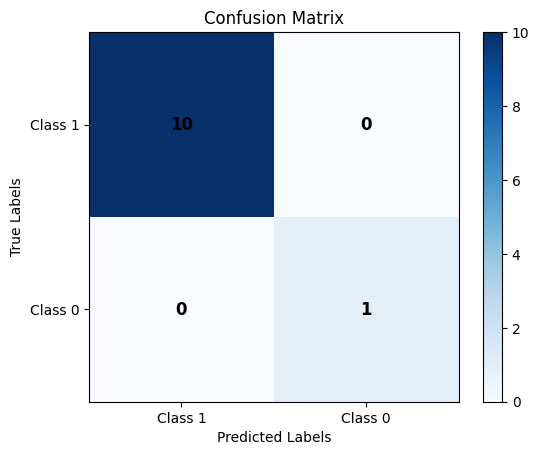

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_val)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Set the tick labels
class_labels = ["Class 1", "Class 0"]
plt.xticks(np.arange(len(class_labels)), labels=class_labels)
plt.yticks(np.arange(len(class_labels)), labels=class_labels)

# Add cell values as annotations with darker color
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=12, weight='bold')

plt.show()


Confusion Matrix:
[[36  0]
 [ 0  6]]


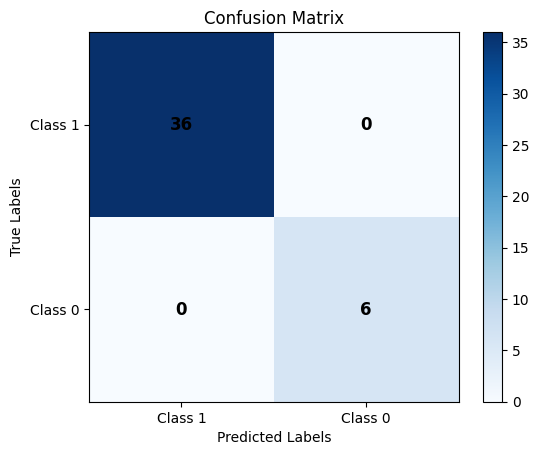

In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, y_pred_train)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Set the tick labels
class_labels = ["Class 1", "Class 0"]
plt.xticks(np.arange(len(class_labels)), labels=class_labels)
plt.yticks(np.arange(len(class_labels)), labels=class_labels)

# Add cell values as annotations with darker color
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=12, weight='bold')

plt.show()


In [45]:
y_train.value_counts()

0    36
1     6
Name: ranking_SBERT_binary, dtype: int64

Certainly! Here's the solution explained in Markdown format:

#### Algorithm Overview

The proposed solution utilizes a LambdaRank model, which is a learning-to-rank algorithm based on gradient boosting with LightGBM. The algorithm is trained to optimize the ranking of candidates based on their relevance scores (ranking_SBERT_binary) and similarity scores (similarities_SBERT).

#### Step-by-Step Explanation

1. **Prepare the dataset:** The dataset is prepared by extracting the relevant features (`similarities_SBERT`) and the target variable (`ranking_SBERT_binary`). The query IDs (`qid`) are set to be the same for all instances since all queries are the same in this case.

2. **Define the ranking metric (NDCG):** NDCG (Normalized Discounted Cumulative Gain) is chosen as the evaluation metric. It measures the quality of the ranking by comparing the predicted relevance scores with the true relevance labels.

3. **Design the LambdaRank model:** The LambdaRank model is instantiated using LightGBM's LGBMRanker class.

4. **Train the LambdaRank model:** The model is trained using the training data (`X_train`, `y_train`) and the query IDs (`qid_train`). The evaluation set (`X_val`, `y_val`) and its corresponding query IDs (`qid_val`) are used for monitoring the model's performance during training.

5. **Evaluate the LambdaRank model:** After training, the model's performance is evaluated on the validation set using the NDCG metric. The NDCG score on the validation set gives an indication of the model's ranking performance.

6. **Use the LambdaRank model for ranking new instances:** Once the model is trained and evaluated, it can be used to rank new instances. In the provided code, the model is used to rank a few sample instances (`new_instances`) and the ranking scores are obtained.

#### Filtering Candidates and Determining Cut-off Point

To filter out candidates that should not be in the list, you can apply a threshold on the ranking scores. For example, you can set a minimum threshold for the ranking score and consider only the candidates above that threshold. This will help in excluding candidates that are ranked lower and may not be suitable for the role.

Determining a cut-off point that works for other roles without losing high potential candidates can be challenging. It requires balancing between inclusiveness and precision. One approach is to analyze the distribution of ranking scores and determine a threshold based on a specific percentile or a predefined range. This way, you can capture a certain percentage of candidates with higher potential while reducing the number of candidates that may not be suitable.

#### Automating the Procedure to Prevent Human Bias

To automate the procedure and prevent human bias, consider the following ideas:

1. **Collect diverse and representative training data:** Ensure that the training data includes candidates from various backgrounds and demographics to minimize bias. Consider using anonymized data to remove any identifiable information that may introduce bias.

2. **Regularly update and retrain the model:** Keep updating the model with new data and retrain it periodically to capture changing trends and avoid the model from being biased towards older data.

3. **Monitor and address bias in the data:** Continuously monitor the performance of the model and analyze its behavior. Identify any bias in the model's predictions and take corrective actions, such as adjusting the training data, redefining features, or applying fairness-aware algorithms.

4. **Include fairness metrics:** Incorporate fairness metrics during the model evaluation process to measure and track potential biases in the ranking outcomes. This can help in identifying and addressing any discriminatory patterns.

5. **Involve diverse stakeholders:** Include a diverse set of stakeholders, such as domain experts, ethicists, and individuals from different backgrounds, in the decision-making process. This can help in

 identifying and mitigating biases and ensuring a more inclusive and fair ranking procedure.

It's important to note that automated procedures can assist in reducing human bias, but regular monitoring and involvement of diverse stakeholders are crucial to ensure fairness and inclusivity in the ranking process.